In [1]:
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
from gan_model import Discriminator, Generator
from fid_score import *
from inception import *

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [5]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_test = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=10000)
for img in dataloader_test:
    test_imgs=img[0].to(dev)

Files already downloaded and verified


In [6]:
epochs = 30
gen_count_to_test = 7
file_loc = [
'runs/2W_CTDC_MAX_LOSS_OVERR_1to1_same_lr/models/G_epoch_150',
'runs/2W_CTDC_MIN_LOSS_OVERR_1to1_same_lr/models/G_epoch_150',
'runs/2W_CTDC_MAX_LOSS/models/G_epoch_150',
'runs/2W_CTDC_MIN_LOSS/models/G_epoch_150',
'runs/2W_CTDC_WAVG_MAXLOSS_1to1_same_lr/models/g_EPOCH_100',
'runs/2W_CTDC_WAVG_MAXLOSS_1to1_diff_lr/models/g_EPOCH_150',
'runs/2W_CDTC_WAVG_MAXLOSS_3to1_same_lr/models/g_EPOCH_150',
]
assert gen_count_to_test == len(file_loc)

NOISE_DIM = 128
FID_BATCH_SIZE = 25
fic_model = InceptionV3().to(dev)
generators = {}
for i in range(gen_count_to_test):
    key = f'gen{i}'
    generators[key] = Generator().to(dev)
    generators[key].load_state_dict(torch.load(file_loc[i]))


In [7]:
fid_avg = []
for epoch in range(epochs):
    fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
    random_start = np.random.randint(len(test_imgs)-FID_BATCH_SIZE)
    for i,gen in enumerate(generators.values()):
        if epoch == 0:
            fid_avg.append([])
        gen_imgs = gen(fid_z.detach())
        mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
        mu_test, sigma_test = calculate_activation_statistics(test_imgs[random_start:random_start+FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
        fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
        fid_avg[i].append(fid)
        print(f'gen#{i}/epoch#{epoch} fid_score: {fid:0.2f}')

gen#0/epoch#0 fid_score: 235.08
gen#1/epoch#0 fid_score: 232.36
gen#2/epoch#0 fid_score: 236.23
gen#3/epoch#0 fid_score: 225.62
gen#4/epoch#0 fid_score: 240.49
gen#5/epoch#0 fid_score: 232.25
gen#6/epoch#0 fid_score: 228.28
gen#0/epoch#1 fid_score: 247.21
gen#1/epoch#1 fid_score: 219.90
gen#2/epoch#1 fid_score: 211.83
gen#3/epoch#1 fid_score: 226.84
gen#4/epoch#1 fid_score: 231.78
gen#5/epoch#1 fid_score: 227.34
gen#6/epoch#1 fid_score: 248.69
gen#0/epoch#2 fid_score: 223.97
gen#1/epoch#2 fid_score: 232.36
gen#2/epoch#2 fid_score: 236.01
gen#3/epoch#2 fid_score: 223.71
gen#4/epoch#2 fid_score: 239.23
gen#5/epoch#2 fid_score: 241.99
gen#6/epoch#2 fid_score: 229.29
gen#0/epoch#3 fid_score: 230.09
gen#1/epoch#3 fid_score: 240.39
gen#2/epoch#3 fid_score: 242.63
gen#3/epoch#3 fid_score: 217.01
gen#4/epoch#3 fid_score: 233.98
gen#5/epoch#3 fid_score: 236.41
gen#6/epoch#3 fid_score: 236.25
gen#0/epoch#4 fid_score: 231.91
gen#1/epoch#4 fid_score: 221.86
gen#2/epoch#4 fid_score: 233.00
gen#3/ep

In [8]:
fid_avg_np = np.array(fid_avg)
print(fid_avg_np.mean(axis=1))
print(fid_avg_np.std(axis=1))

[231.68202849 230.63486811 229.35921875 221.54785371 229.61516122
 229.9450671  230.72293196]
[ 9.38871204 11.41368945 11.4745674   9.34148311  9.19361145  6.81609563
  9.26797797]


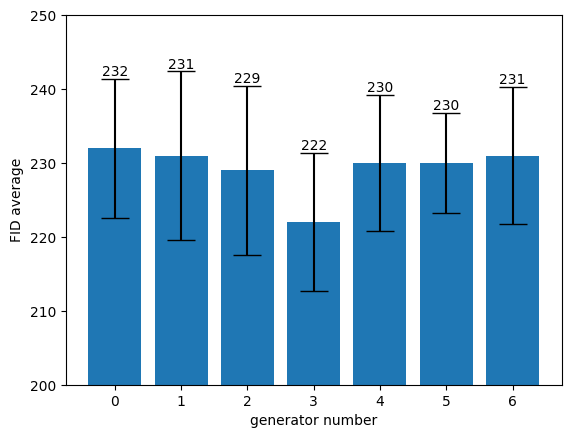

In [9]:
x = range(len(generators))
bars = plt.bar(x,np.around(fid_avg_np.mean(axis=1)),yerr=fid_avg_np.std(axis=1),align='center',ecolor='black',capsize=10)
plt.bar_label(bars,label_type='edge')
plt.xticks(range(len(x)), x)
plt.xlabel('generator number')
plt.ylabel('FID average')
plt.ylim([200,250])
# plt.savefig('{}/worker_cont.png'.format(logger.writer.logdir))
plt.show()